<a href="https://colab.research.google.com/github/w1767/w1767/blob/main/ARIMA_LSTM_RL%5B1%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arch
#Importing libraries
import tensorflow
import glob
import csv
from pathlib import Path
import pandas as pd
from arch import arch_model
import os

#Checking the buisness day's
from pandas.tseries.offsets import BDay

# suppress future warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore')

#import Datetime for timeseries data
import datetime as dt
from datetime import datetime, timedelta

#Import Visualisation tools
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style

# Import math and numpy for calculations
import numpy as np
import math
from math import sqrt
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint

# Import statsmodels for Arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Import Keras 
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.optimizer_v2 import adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
from keras.optimizers import adam_v2
from keras.layers.convolutional import Conv1D   
from keras.layers import Dense, Activation, Flatten
from keras.models import Sequential
from keras.utils.vis_utils import plot_model

#importing Sklearn and its functions
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 902 kB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 34.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
path = "/content/drive/MyDrive/PhD research/VIX_daily.xlsx" #importing dataset

In [10]:
df=pd.read_excel("/content/drive/MyDrive/PhD research/VIX_daily.xlsx", index_col = 'Date')
             #  parse_dates=["Date"],
             #  index_col=["Date"]) # parse the date column and tell pandas that column 1 is a datetime)

In [ ]:
#path = "/content/drive/MyDrive/PhD research/VIX daily.xlsx"

In [12]:
#printing overview of dataset
df

,Last Price
Date,
2022-04-20,21.19
2022-04-19,21.37
2022-04-18,22.17
2022-04-14,22.70
2022-04-13,21.82
...,...
1990-01-08,20.26
1990-01-05,20.11
1990-01-04,19.22


In [13]:
df.isnull().any()

Last Price    False
dtype: bool

In [14]:
df.info() #printing the statistics of dataframe

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8136 entries, 2022-04-20 to 1990-01-02
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Last Price  8136 non-null   float64
dtypes: float64(1)
memory usage: 127.1 KB


In [16]:
len(df) #length

8136

In [18]:
df.index

DatetimeIndex(['2022-04-20', '2022-04-19', '2022-04-18', '2022-04-14',
               '2022-04-13', '2022-04-12', '2022-04-11', '2022-04-08',
               '2022-04-07', '2022-04-06',
               ...
               '1990-01-15', '1990-01-12', '1990-01-11', '1990-01-10',
               '1990-01-09', '1990-01-08', '1990-01-05', '1990-01-04',
               '1990-01-03', '1990-01-02'],
              dtype='datetime64[ns]', name='Date', length=8136, freq=None)

In [19]:
## Checkning the business day's in the dataframe

from pandas.tseries.offsets import BDay

isBusinessDay = BDay().onOffset
match_series = pd.to_datetime(df.index).map(isBusinessDay)
match_series

Index([True, True, True, True, True, True, True, True, True, True,
       ...
       True, True, True, True, True, True, True, True, True, True],
      dtype='object', name='Date', length=8136)

In [ ]:
#VIX_daily['Date'] = (VIX_daily['Date'].apply(lambda x: float(x[0].replace(',', ''))))

In [ ]:
#df.dropna()

,Date,Last Price,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7


In [ ]:
#df['Date'] = pd.to_datetime(VIX_daily['Date'], errors='coerce', utc= True)

In [22]:
df.index.dayofweek.nunique() #printing the number of unique value according to the data of week
#dataset containes only the week days

5

In [ ]:
#VIX_daily.shape

(8136, 2)

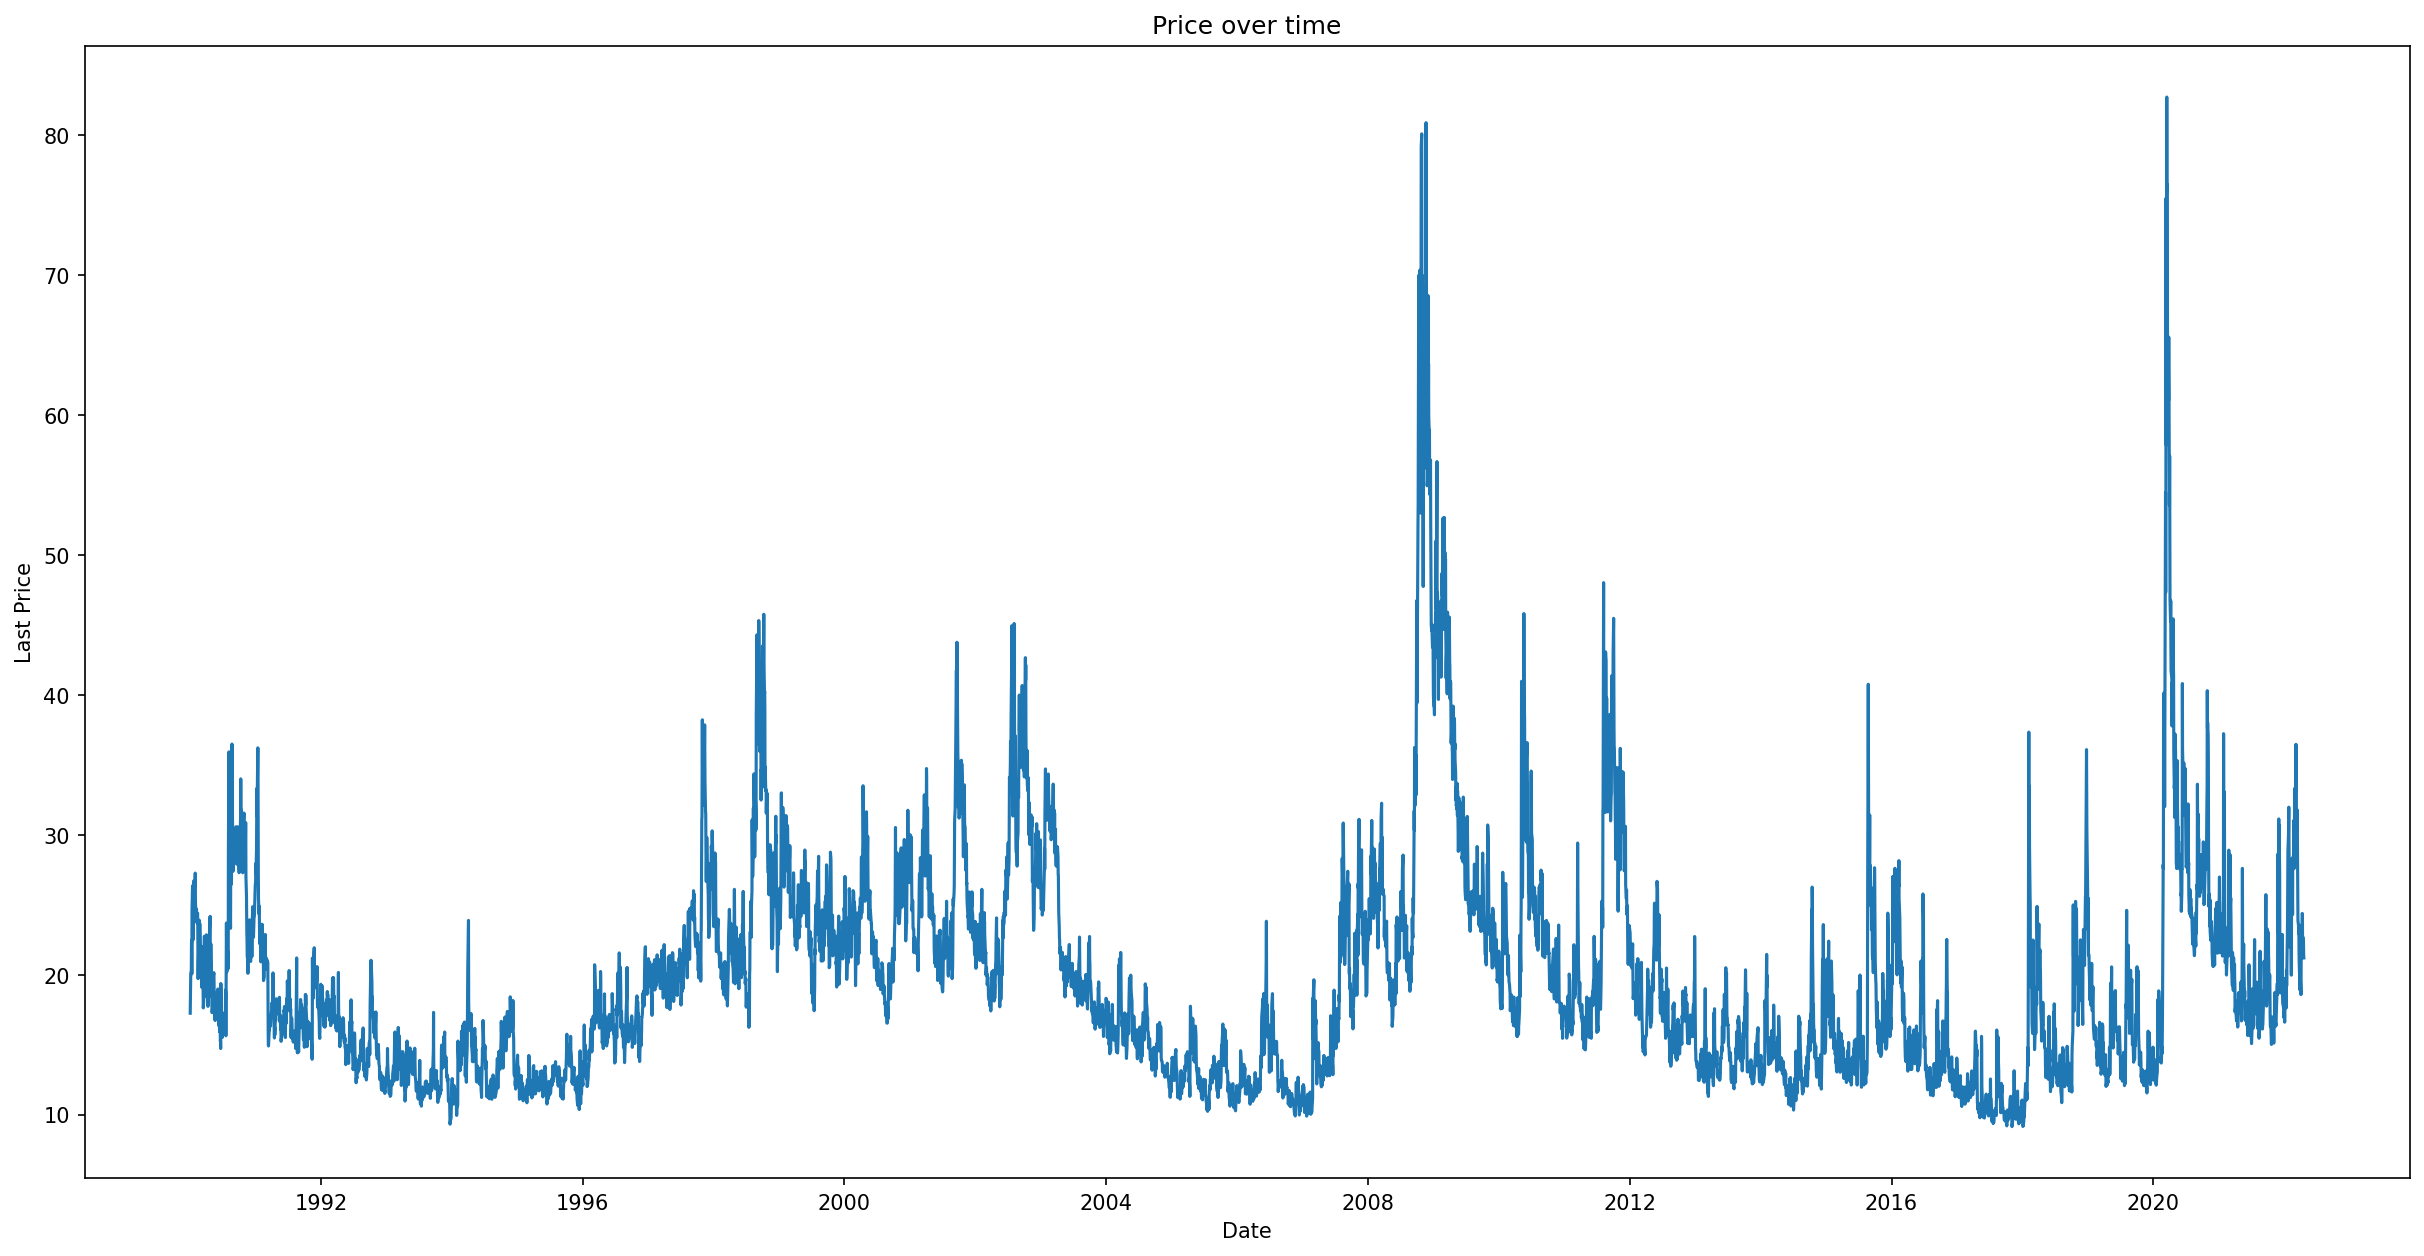

In [23]:
plt.figure(figsize=(20, 10), dpi=150) #plotting time series to check frequency and trend
plt.plot(df.index, df['Last Price'], color='tab:blue')
plt.gca().set(title='Price over time', 
xlabel='Date', ylabel='Last Price')
plt.show()

In [24]:
#Determine rolling statistics
rolmean = df['Last Price'].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = df['Last Price'].rolling(window=12).std()
print(rolmean,rolstd)

Date
2022-04-20          NaN
2022-04-19          NaN
2022-04-18          NaN
2022-04-14          NaN
2022-04-13          NaN
                ...    
1990-01-08    23.544167
1990-01-05    23.160000
1990-01-04    22.536667
1990-01-03    22.177500
1990-01-02    21.585833
Name: Last Price, Length: 8136, dtype: float64 Date
2022-04-20         NaN
2022-04-19         NaN
2022-04-18         NaN
2022-04-14         NaN
2022-04-13         NaN
                ...   
1990-01-08    2.108155
1990-01-05    2.286868
1990-01-04    2.253419
1990-01-03    2.579659
1990-01-02    2.839697
Name: Last Price, Length: 8136, dtype: float64


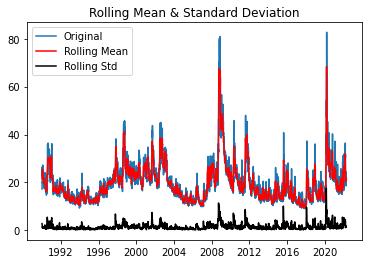

In [25]:
#Plot rolling statistics
import matplotlib.pyplot as plt
import numpy as np
orig = plt.plot(df, color='tab:blue', label= 'Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

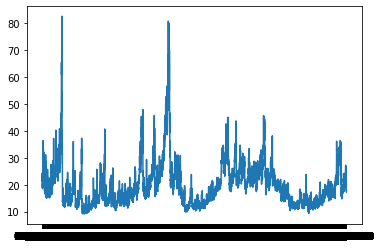

In [ ]:
#Plot rolling statistics
#orig = plt.plot(VIX_daily['Date'], VIX_daily['Last Price'], color='tab:blue')

In [26]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['Last Price'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -6.711864e+00
p-value                        3.663477e-09
#Lags Used                     1.000000e+01
Number of Observations Used    8.125000e+03
Critical Value (1%)           -3.431155e+00
Critical Value (5%)           -2.861896e+00
Critical Value (10%)          -2.566959e+00
dtype: float64


p-value is the probability. should be smaller than 0.05. 

In [28]:
#Estimating trend/ taking logs of data series

Dataset_logScale = np.log(df['Last Price'])
Dataset_logScale = Dataset_logScale.dropna()
Dataset_logScale

Date
2022-04-20    3.053529
2022-04-19    3.061988
2022-04-18    3.098740
2022-04-14    3.122365
2022-04-13    3.082827
                ...   
1990-01-08    3.008648
1990-01-05    3.001217
1990-01-04    2.955951
1990-01-03    2.900872
1990-01-02    2.847232
Name: Last Price, Length: 8136, dtype: float64

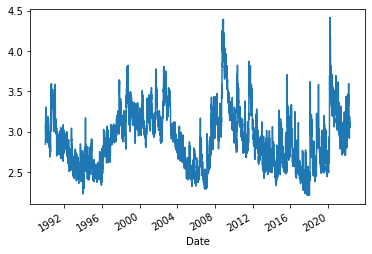

In [29]:
Dataset_logScale.plot()

In [31]:
#Log difference/ returns 
Log_Return= df['Last Price'].pct_change()
Log_Return = Dataset_Return.dropna()
Log_Return

Date
2022-04-19    0.008495
2022-04-18    0.037436
2022-04-14    0.023906
2022-04-13   -0.038767
2022-04-12    0.111824
                ...   
1990-01-08   -0.087387
1990-01-05   -0.007404
1990-01-04   -0.044257
1990-01-03   -0.053590
1990-01-02   -0.052226
Name: Last Price, Length: 8135, dtype: float64

In [32]:
# copy the data and Normalise it
df_min_max_scaled = Dataset_logScale.copy()

# apply normalization techniques on logged data
for i in df_min_max_scaled:
    df_min_max_scaled  = (df_min_max_scaled  - df_min_max_scaled .min()) / (df_min_max_scaled .max() - df_min_max_scaled .min())

# view normalized data
print(df_min_max_scaled)

Date
2022-04-20    0.381790
2022-04-19    0.385631
2022-04-18    0.402318
2022-04-14    0.413044
2022-04-13    0.395092
                ...   
1990-01-08    0.361412
1990-01-05    0.358038
1990-01-04    0.337486
1990-01-03    0.312477
1990-01-02    0.288122
Name: Last Price, Length: 8136, dtype: float64


In [33]:
!pip install pmdarima
from statsmodels.tsa.arima.model import ARIMA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.2 MB/s 


auto

## On Normal Data Value

The Akaike information criterion (AIC) is a mathematical method for evaluating how well a model fits the data it was generated from. In statistics, AIC is used to compare different possible models and determine which one is the best fit for the data.The AIC function is 2K – 2(log-likelihood) = 2*(K - LL). Lower AIC values indicate a better-fit model. 
BIC = ln(n)k - 2l. https://www.roadlesstraveledstore.com/how-do-i-choose-between-aic-and-bic/.
k = number of variables or input features or columns in the model. k is the numner of parameters estimated. 


In [59]:
#data shape
print(df_min_max_scaled.shape)

#making the train and test split

train=df_min_max_scaled.iloc[:-30]
test=df_min_max_scaled.iloc[-30:]

#print the data shape
print(train.shape, test.shape)
print(test.iloc[0],test.iloc[-1])

(8136,)
(8106,) (30,)
0.44546207851647696 0.2881224334745227


In [ ]:
#ARIMA MODEL

In [36]:
model = ARIMA(train, order = (1, 0, 5))  #fit arima on train data
model = model.fit()  

In [38]:
model.summary() # print summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Last Price   No. Observations:                 8106
Model:                 ARIMA(1, 0, 5)   Log Likelihood               16858.285
Date:                Tue, 24 May 2022   AIC                         -33700.571
Time:                        15:50:48   BIC                         -33644.568
Sample:                             0   HQIC                        -33681.415
                               - 8106                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3152      0.026     12.163      0.000       0.264       0.366
ar.L1          0.9897      0.001    670.901      0.000       0.987       0.993
ma.L1         -0.0955      0.007    -12.910      0.000      -0.110      -0.081
ma.L2         -0.0628      0.008     -7.972      0.000      -0.078      -0.047
ma.L3         -0.0397      0.009     -4.666      0.000      -0.056      -0.023
ma.L4         -0.0475      0.009     -5.389      0.000      -0.065      -0.030
ma.L5         -0.0220      0.008     -2.602      0.009      -0.039      -0.005
sigma2         0.0009   8.13e-06    112.342      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             11602.49
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
data = model.fittedvalues #print the fitted values (predicted values)
data  

Date
2022-04-20    0.315159
2022-04-19    0.380511
2022-04-18    0.384087
2022-04-14    0.399271
2022-04-13    0.409386
                ...   
1990-02-20    0.431740
1990-02-16    0.413379
1990-02-15    0.376839
1990-02-14    0.353521
1990-02-13    0.398110
Length: 8106, dtype: float64

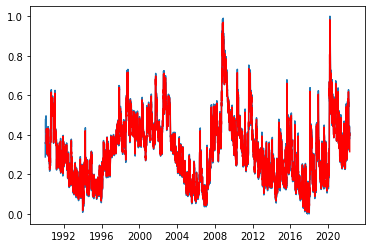

In [40]:
# plotting actual vs predict 
plt.plot(df_min_max_scaled)
plt.plot(model.fittedvalues, color='red')

In [41]:
predictions_ARIMA_diff = pd.Series(model.fittedvalues) #calculating the difference
print(predictions_ARIMA_diff)

Date
2022-04-20    0.315159
2022-04-19    0.380511
2022-04-18    0.384087
2022-04-14    0.399271
2022-04-13    0.409386
                ...   
1990-02-20    0.431740
1990-02-16    0.413379
1990-02-15    0.376839
1990-02-14    0.353521
1990-02-13    0.398110
Length: 8106, dtype: float64


In [44]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum() # convert to cumul. sum
print(predictions_ARIMA_diff_cumsum)
 

Date
2022-04-20       0.315159
2022-04-19       0.695670
2022-04-18       1.079758
2022-04-14       1.479029
2022-04-13       1.888415
                 ...     
1990-02-20    2544.710788
1990-02-16    2545.124167
1990-02-15    2545.501006
1990-02-14    2545.854528
1990-02-13    2546.252638
Length: 8106, dtype: float64


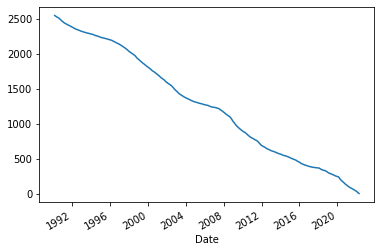

In [46]:
# plotting the predictive plot to check the overall future trend

predictions_ARIMA_log = pd.Series(df_min_max_scaled, index=df_min_max_scaled.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum)
predictions_ARIMA_log.plot()

In [54]:
start=len(train) 
end=len(train)+len(test)-1
#if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a graph
index_future_dates=pd.date_range(start=start,end=end)
pred=model.predict(start=start,end=end ).rename('ARIMA predictions')

In [60]:
pred.head

<bound method NDFrame.head of 8106    0.429635
8107    0.426594
8108    0.422442
8109    0.418618
8110    0.416765
8111    0.415716
8112    0.414679
8113    0.413652
8114    0.412635
8115    0.411630
8116    0.410634
8117    0.409649
8118    0.408674
8119    0.407709
8120    0.406754
8121    0.405809
8122    0.404874
8123    0.403948
8124    0.403032
8125    0.402125
8126    0.401228
8127    0.400339
8128    0.399461
8129    0.398591
8130    0.397730
8131    0.396878
8132    0.396035
8133    0.395200
8134    0.394374
8135    0.393557
Name: ARIMA predictions, dtype: float64>

In [55]:
# Printing the RMSE of ARIMA model

rmse=sqrt(mean_squared_error(pred, test))
print(rmse)

0.05168351378326319


In [ ]:
#adf_test(df_min_max_scaled)

1. ADF :  -5.910609444040219
2. P-Value :  2.644357297212957e-07
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 8124
5. Critical Values :
	 1% :  -3.4311551904760065
	 5% :  -2.861895837245016
	 10% :  -2.5669594074059123


In [ ]:
#adf_test(VIX_daily['Last Price'])

1. ADF :  -6.711863740946838
2. P-Value :  3.663477254210863e-09
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 8125
5. Critical Values :
	 1% :  -3.4311550913443045
	 5% :  -2.8618957934417497
	 10% :  -2.566959384088994


In [57]:
#adf_test(Dataset_logScale)

NameError: ignored

In [ ]:
#adf_test(Dataset_Return)

1. ADF :  -23.928622559697843
2. P-Value :  0.0
3. Num Of Lags :  33
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 12212
5. Critical Values :
	 1% :  -3.430885594094518
	 5% :  -2.8617767054517396
	 10% :  -2.5668959932869027


In [ ]:
#from pmdarima import auto_arima
# Ignore harmless warnings
#import warnings
#warnings.filterwarnings("ignore")

In [ ]:
#stepwise_fit = auto_arima(Dataset_logScale, 
 #                         suppress_warnings=True)           

#stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8136
Model:               SARIMAX(1, 1, 2)   Log Likelihood               10490.848
Date:                Fri, 20 May 2022   AIC                         -20973.696
Time:                        13:20:02   BIC                         -20945.680
Sample:                             0   HQIC                        -20964.115
                               - 8136                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8682      0.016     54.866      0.000       0.837       0.899
ma.L1         -0.9729      0.018    -54.858      0.000      -1.008      -0.938
ma.L2          0.0381      0.009      4.095      0.000       0.020       0.056
sigma2         0.0044   3.78e-05    117.518      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11880.09
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#from statsmodels.tsa.arima_model import ARIMA

In [ ]:
#from pmdarima import auto_arima
# Ignore harmless warnings
#import warnings
#warnings.filterwarnings("ignore")

#stepwise_fit = auto_arima(df_min_max_scaled,
#suppress_warnings=True)

#stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8136
Model:               SARIMAX(1, 1, 3)   Log Likelihood               16918.264
Date:                Fri, 20 May 2022   AIC                         -33826.528
Time:                        13:23:11   BIC                         -33791.508
Sample:                             0   HQIC                        -33814.551
                               - 8136                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9496      0.006    152.762      0.000       0.937       0.962
ma.L1         -1.0554      0.010   -106.353      0.000      -1.075      -1.036
ma.L2          0.0293      0.011      2.754      0.006       0.008       0.050
ma.L3          0.0408      0.008      4.886      0.000       0.024       0.057
sigma2         0.0009   7.94e-06    115.182      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11548.39
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMAX - ACCOUNTS FOR DATA SEASONALITY

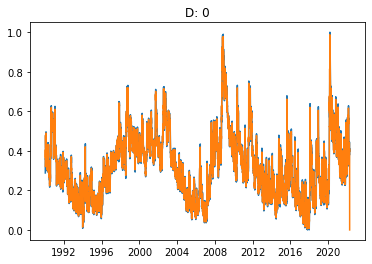

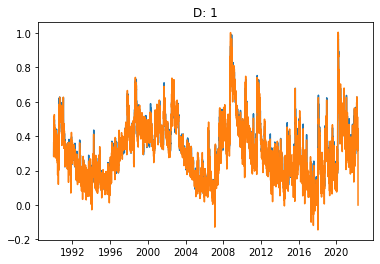

In [56]:
import statsmodels.api



for cd in range(2):

    m = statsmodels.api.tsa.statespace.SARIMAX(
                                                    endog = df_min_max_scaled,
                                                    order = (1,1,1),
                                                    seasonal_order = (0,cd,0,12),
                                                    trend = 'n'
                                               ).fit()


    plt.plot(df_min_max_scaled)
    plt.plot(m.fittedvalues)
    plt.title('D: ' + str(cd))
    plt.show()

In [58]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          Last Price   No. Observations:                 8136
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood               14309.273
Date:                             Tue, 24 May 2022   AIC                         -28612.546
Time:                                     16:30:53   BIC                         -28591.539
Sample:                                          0   HQIC                        -28605.361
                                            - 8136                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8555      0.004    227.360      0.000       0.848       0.863
ma.L1         -1.0000      0.151     -6.620      0.000      -1.296      -0.704
sigma2         0.0017      0.000      6.562      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              3468.50
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#from statsmodels.tsa.arima_model import ARIMA
#print(df_min_max_scaled.shape)
#train=df_min_max_scaled.iloc[:-30]
#test=df_min_max_scaled.iloc[-30:]
#print(train.shape,test.shape)
#print(test.iloc[0],test.iloc[-1])

(8136,)
(8106,) (30,)
0.44546207851647696 0.2881224334745227


In [ ]:
#from statsmodels.tsa.arima.model import ARIMA
#model=ARIMA(train,order=(1,0,5))
#model=model.fit()
#model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Last Price   No. Observations:                 8106
Model:                 ARIMA(1, 0, 5)   Log Likelihood               16858.285
Date:                Fri, 20 May 2022   AIC                         -33700.571
Time:                        13:24:20   BIC                         -33644.568
Sample:                             0   HQIC                        -33681.415
                               - 8106                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3152      0.026     12.163      0.000       0.264       0.366
ar.L1          0.9897      0.001    670.901      0.000       0.987       0.993
ma.L1         -0.0955      0.007    -12.910      0.000      -0.110      -0.081
ma.L2         -0.0628      0.008     -7.972      0.000      -0.078      -0.047
ma.L3         -0.0397      0.009     -4.666      0.000      -0.056      -0.023
ma.L4         -0.0475      0.009     -5.389      0.000      -0.065      -0.030
ma.L5         -0.0220      0.008     -2.602      0.009      -0.039      -0.005
sigma2         0.0009   8.13e-06    112.342      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             11602.49
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#data = model.fittedvalues

#data

0       0.315159
1       0.380511
2       0.384087
3       0.399271
4       0.409386
          ...   
8101    0.431740
8102    0.413379
8103    0.376839
8104    0.353521
8105    0.398110
Length: 8106, dtype: float64

Text(0.5, 1.0, 'RSS: nan')

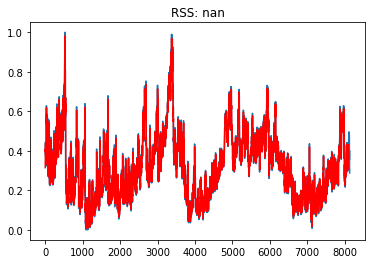

In [ ]:
#plt.plot(df_min_max_scaled)
#plt.plot(model.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((model.fittedvalues-df_min_max_scaled)**2))

In [ ]:
#predictions_ARIMA_diff = pd.Series(model.fittedvalues)
#print (predictions_ARIMA_diff)

0       0.315159
1       0.380511
2       0.384087
3       0.399271
4       0.409386
          ...   
8101    0.431740
8102    0.413379
8103    0.376839
8104    0.353521
8105    0.398110
Length: 8106, dtype: float64


In [ ]:
#Convert to cumulative sum

#predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
#print (predictions_ARIMA_diff_cumsum)

0          0.315159
1          0.695670
2          1.079758
3          1.479029
4          1.888415
           ...     
8101    2544.710788
8102    2545.124167
8103    2545.501006
8104    2545.854528
8105    2546.252638
Length: 8106, dtype: float64


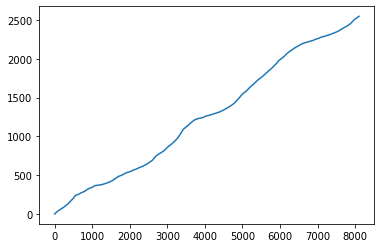

In [ ]:
#predictions_ARIMA_log = pd.Series(df_min_max_scaled, index=df_min_max_scaled.index)
#predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum)
#predictions_ARIMA_log.plot()

In [ ]:
#start=len(train) 
#end=len(train)+len(test)-1
#if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a graph
#index_future_dates=pd.date_range(start=start,end=end)
#pred=model.predict(start=start,end=end ).rename('ARIMA predictions')

In [ ]:
#pred.head()

8106    0.429635
8107    0.426594
8108    0.422442
8109    0.418618
8110    0.416765
Name: ARIMA predictions, dtype: float64

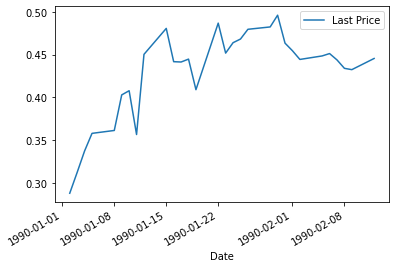

In [61]:
test.plot(legend=True)

In [62]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test))
mse = metrics.mean_squared_error(pred, test)
print(rmse)
print (mse)

0.05168351378326319
0.002671185596984756


LSTM

In [ ]:
final_data = pd.DataFrame(data, columns=['Price'])

In [ ]:
final_data

,Price
0,0.315159
1,0.380511
2,0.384087
3,0.399271
4,0.409386
...,...
8101,0.431740
8102,0.413379
8103,0.376839
8104,0.353521


In [ ]:
# split into train and test sets
train_set = int(len(final_data) * 0.7)
test_set = len(final_data) - train_set
train = final_data[test_set:len(final_data)]
test = final_data[train_set:len(final_data)]
print(len(train), len(test))

5674 2432


In [ ]:
train.values

array([[0.23005943],
       [0.20045253],
       [0.18270798],
       ...,
       [0.37683929],
       [0.35352126],
       [0.39811032]])

In [ ]:
test.shape

(2432, 1)

In [ ]:
print(index_future_dates)

DatetimeIndex(['1970-01-01 00:00:00.000008106'], dtype='datetime64[ns]', freq='D')


In [ ]:
VIX_daily.shape[0]

8136

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

training_set = df.iloc[:, 1:2].values
X_train = []
y_train = []

for i in range(100, VIX_daily.shape[0]):
    X_train.append(training_set[i-100:i,0])
    y_train.append(training_set[i,0])
    if i<=101:
     print(X_train)
     print(y_train)
     print()

[array([21.19, 21.37, 22.17, 22.7 , 21.82, 24.26, 24.37, 21.16, 21.55,
       22.1 , 21.03, 18.57, 19.63, 20.56, 19.33, 18.9 , 19.63, 20.81,
       21.67, 23.57, 22.94, 23.53, 23.87, 25.67, 26.67, 29.83, 31.77,
       30.75, 30.23, 32.45, 35.13, 36.45, 31.98, 30.48, 30.74, 33.32,
       30.15, 27.59, 30.32, 31.02, 28.81, 27.75, 28.11, 24.29, 25.7 ,
       28.33, 27.36, 23.91, 19.96, 21.44, 22.86, 23.22, 24.35, 22.09,
       21.96, 24.83, 27.66, 30.49, 31.96, 31.16, 29.9 , 28.85, 25.59,
       23.85, 22.79, 19.19, 20.31, 17.62, 18.41, 19.4 , 18.76, 19.61,
       19.73, 16.91, 16.6 , 17.22, 17.33, 16.95, 17.54, 17.68, 17.96,
       18.63, 21.01, 22.87, 21.57, 20.57, 19.29, 21.89, 20.31, 18.69,
       21.58, 19.9 , 21.89, 27.18, 30.67, 27.95, 31.12, 27.19, 22.96,
       28.62])]
[18.58]

[array([21.19, 21.37, 22.17, 22.7 , 21.82, 24.26, 24.37, 21.16, 21.55,
       22.1 , 21.03, 18.57, 19.63, 20.56, 19.33, 18.9 , 19.63, 20.81,
       21.67, 23.57, 22.94, 23.53, 23.87, 25.67, 26.67, 29.83, 

In [ ]:
len(y_train), len(X_train)

(8036, 8036)

In [ ]:
test_set = df.iloc[:, 1:2].values
X_test = []
y_test = []

for i in range(100, VIX_daily.shape[0]):
    X_test.append(test_set[i-100:i,0])
    y_test.append(test_set[i,0])
    if i<=100:
     print(X_test)
     print(y_test)
     print()

[array([21.19, 21.37, 22.17, 22.7 , 21.82, 24.26, 24.37, 21.16, 21.55,
       22.1 , 21.03, 18.57, 19.63, 20.56, 19.33, 18.9 , 19.63, 20.81,
       21.67, 23.57, 22.94, 23.53, 23.87, 25.67, 26.67, 29.83, 31.77,
       30.75, 30.23, 32.45, 35.13, 36.45, 31.98, 30.48, 30.74, 33.32,
       30.15, 27.59, 30.32, 31.02, 28.81, 27.75, 28.11, 24.29, 25.7 ,
       28.33, 27.36, 23.91, 19.96, 21.44, 22.86, 23.22, 24.35, 22.09,
       21.96, 24.83, 27.66, 30.49, 31.96, 31.16, 29.9 , 28.85, 25.59,
       23.85, 22.79, 19.19, 20.31, 17.62, 18.41, 19.4 , 18.76, 19.61,
       19.73, 16.91, 16.6 , 17.22, 17.33, 16.95, 17.54, 17.68, 17.96,
       18.63, 21.01, 22.87, 21.57, 20.57, 19.29, 21.89, 20.31, 18.69,
       21.58, 19.9 , 21.89, 27.18, 30.67, 27.95, 31.12, 27.19, 22.96,
       28.62])]
[18.58]



In [ ]:
len(y_test), len(X_test)

(8036, 8036)

In [ ]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
#Reshape the data
#X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))
#X_train.shape

(8036, 100, 1)

In [ ]:
X_train, y_train

(array([[21.19, 21.37, 22.17, ..., 27.19, 22.96, 28.62],
        [21.37, 22.17, 22.7 , ..., 22.96, 28.62, 18.58],
        [22.17, 22.7 , 21.82, ..., 28.62, 18.58, 19.38],
        ...,
        [18.75, 17.32, 17.7 , ..., 22.2 , 20.26, 20.11],
        [17.32, 17.7 , 17.18, ..., 20.26, 20.11, 19.22],
        [17.7 , 17.18, 17.84, ..., 20.11, 19.22, 18.19]]),
 array([18.58, 19.38, 19.17, ..., 19.22, 18.19, 17.24]))

In [ ]:
X_train.shape, X_train.size

((8036, 100), 803600)

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(1, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

8036/8036 - 113s - loss: 103.5205 - 113s/epoch - 14ms/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1)                 12        
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# make predictions
Predict = model.predict(test)

In [ ]:
import math
# calculate root mean squared error
Score = math.sqrt(mean_squared_error(test, Predict))
print('Train Score: %.2f RMSE' % (Score))

Train Score: 9.34 RMSE


In [ ]:
print('MAPE:',mean_absolute_percentage_error(test, Predict))

MAPE: 41.139566830681076


In [ ]:
print('MAE:', MAE(test, Predict))

MAE: 9.343358097564254


RF

In [ ]:
rf= RandomForestRegressor(n_estimators=30, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 30,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 2,
 'warm_start': False}

In [ ]:
#X_train, X_train.shape

In [ ]:
#y_train, y_train.shape

In [ ]:
#Reshape the data
#dimX1, dimX2, dimX3 = np.array(X_train).shape
#X_train = np.reshape(np.array(X_train), (dimX1*dimX3, dimX2))
#X_train = X_train.reshape(X_train.shape[1:])
#X_train = X_train.transpose()
#X_train.shape

ValueError: ignored

In [ ]:
#X_train

array([[21.19, 21.37, 22.17, ..., 27.19, 22.96, 28.62],
       [21.37, 22.17, 22.7 , ..., 22.96, 28.62, 18.58],
       [22.17, 22.7 , 21.82, ..., 28.62, 18.58, 19.38],
       ...,
       [18.75, 17.32, 17.7 , ..., 22.2 , 20.26, 20.11],
       [17.32, 17.7 , 17.18, ..., 20.26, 20.11, 19.22],
       [17.7 , 17.18, 17.84, ..., 20.11, 19.22, 18.19]])

In [ ]:
#X_train = X_train.reshape(X_train.shape[1:])
#X_train = X_train.transpose()

In [ ]:
#X_train

array([[21.19, 21.37, 22.17, ..., 18.75, 17.32, 17.7 ],
       [21.37, 22.17, 22.7 , ..., 17.32, 17.7 , 17.18],
       [22.17, 22.7 , 21.82, ..., 17.7 , 17.18, 17.84],
       ...,
       [27.19, 22.96, 28.62, ..., 22.2 , 20.26, 20.11],
       [22.96, 28.62, 18.58, ..., 20.26, 20.11, 19.22],
       [28.62, 18.58, 19.38, ..., 20.11, 19.22, 18.19]])

In [ ]:

#dimy1, dimy2, dimy3 = np.array(y_train).shape
#y_train = np.reshape(np.array(y_train),  (dimy1*dimy2, dimy3 ))

ValueError: ignored

In [ ]:
#print(X_train.shape, y_train.shape)

(100, 8036) (8036,)


In [ ]:
rf = rf.fit(X_train, y_train)

building tree 1 of 30
building tree 2 of 30


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.6s finished


In [ ]:
rf.score(X_train, y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished


0.9937273814182833

In [ ]:
rf.score(X_test[:2332], y_test[:2332])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished


0.9907167266101522

In [ ]:
predicted= rf.predict(X_test)

predicted

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished


array([22.36133333, 19.43066667, 19.20366667, ..., 19.548     ,
       19.03      , 17.651     ])

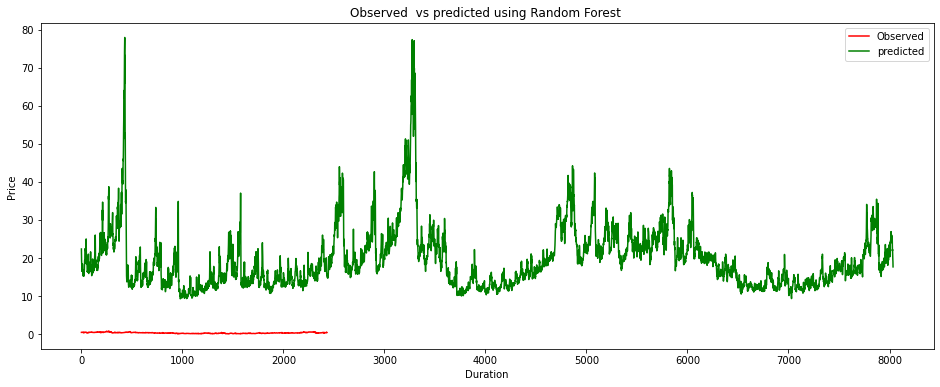

In [ ]:
# Visualising the results
plt.figure(figsize=(16,6))
plt.plot(test.values, color = 'red', label = 'Observed')
plt.plot(predicted, color = 'green', label = 'predicted')
plt.title('Observed  vs predicted using Random Forest ')
plt.xlabel('Duration')
plt.ylabel('Price')
plt.legend()
plt.show()

SVM

In [ ]:
svr_linear = SVR(kernel='linear',C=0.5, gamma=5, epsilon=0.01)
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
SVM = GridSearchCV(svr_linear, parameters)

In [ ]:
SVM.fit(X_train,y_train).predict(X_train)

In [ ]:
SVM.score(X_train, y_train)

In [ ]:
SVm.score(X_test[:2332], y_test[:2332])

In [ ]:
predicted_SVM = clf1.predict(X_train)

In [ ]:
# Visualising the results
plt.figure(figsize=(16,6))
plt.plot(train.values, color = 'red', label = 'Observed')
plt.plot(predicted_SVM, color = 'green', label = 'predicted')
plt.title('Observed  vs predicted using SVM ')
plt.xlabel('Duration')
plt.ylabel('Price')
plt.legend()
plt.show()

SVM Model with RBF Kernel

In [ ]:
# SVM Model with RBF Kernel 
clf = SVR(kernel='rbf') 
clf.fit(X_train, y_train) 

In [ ]:
y_pred = clf.predict(X_test)

print('Accuracy Score: {:.4f}'.format(clf.score(X_train, y_train)))

CNN as descriminator

In [ ]:
x_train =  X_train.reshape(len(X_train), 10*10).astype('float32') 
x_test =  X_test.reshape(len(X_test), 10*10).astype('float32') 

In [ ]:
x_train /= 255
x_test /= 255

In [ ]:
# Data is currently flattened, we need to reshape it back to 10 * 10. To do that we reshape the data.

x_train = np.reshape(x_train, [-1, 10, 10])

x_test = np.reshape(x_test, [-1, 10, 10])

In [ ]:
# model_2 requires input of 32 X 32. So we will pad the train and test images with zeros to increase the size to 32 X 32.

x_train=np.pad(x_train, ((0,0), (11,11), (11, 11)), 'constant')

x_test=np.pad(x_test, ((0,0), (11,11), (11, 11)), 'constant')

In [ ]:
x_train.shape

x_test.shape

In [ ]:
# Convolutional model requires input to be of 3 dimensions. We will add a channel dimension to it.

x_train = np.reshape(x_train, [-1, 32, 32, 1])

x_test = np.reshape(x_test, [-1, 32, 32, 1])

In [ ]:
# convert class labels to one-hot vectors
num_classes = 10
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)

In [ ]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(32,32,1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

In [ ]:
# fit model

batch_size = 128  # mini-batch with 128 examples
epochs = 30
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test))

In [ ]:
yhat = model.predict(x_test, verbose=1)

In [ ]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)
    
plot_loss_accuracy(history)

In [ ]:
# calculate root mean squared error
Score = math.sqrt(mean_squared_error(final_data[:8006], yhat))
print('Train Score: %.2f RMSE' % (Score))

In [ ]:
print('MAPE:',mean_absolute_percentage_error(final_data[:8006], yhat))

In [ ]:
print('MAE:', MAE(final_data[:8006], yhat))

In [ ]:
## We will use Keras evaluate function to evaluate performance on the test set

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score)